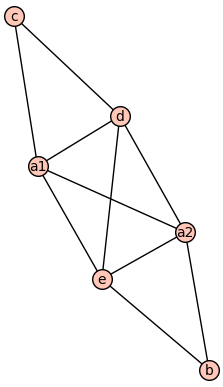

In [25]:
def raag(G):
    # the default notion of raag is backwards...
    return RightAngledArtinGroup(G.complement())

# aaaaand, quick check that it works
#G = raag(graphs.CompleteGraph(5))
#print(G.generators())
#print(G.relations())

# example of interest -- this is the counterexample from Cassals-Ruiz, Duncan, Kazachkov: 
Gamma = Graph([['a1','a2','b','c','d','e'],[('a1','a2'),('a1','d'),('a1','e'),('a2','d'),('a2','e'),('d','e'),('c','d'),('c','a1'),('b','e'),('b','a2')]])
AGamma = raag(Gamma)

# keep in mind this does _not_ play nice with self loops right now.

Gamma.plot()

In [26]:
import itertools

def words(G):
    """
    A lazy list of all the words in the generators of G
    """
    gens = list(G.gens()) + [g.inverse() for g in list(G.gens())]
    i = 1
    while 1:
        for g in itertools.product(*([gens] * i)):
            yield g
        i += 1

In [27]:
def extensionGraph(G, n=10):
    """
    Kim and Koberda define the 'extension graph' and give a related conjecture, which we're testing.
    
    The conjecture is that raag(G) embeds in raag(H) if and only if G embeds in extension(H),
    and is stated in their paper "embedability between right angled artin groups"
    
    @n controls how big we want this finite approximation to extension(G) to be.
    """
    AG = raag(G)
    gens = list(AG.gens())
    
    colors = {gens[i]: rainbow(len(gens))[i] for i in range(len(gens))}
    
    new_vertices = list(AG.gens())
    color = {colors[g]: [g] for g in gens}
    for g in itertools.islice(words(AG),n):
        g = product(list(g))
        for v in gens:
            x = g*v*g.inverse()
            if x not in new_vertices:
                new_vertices.append(x)
                color[colors[v]] += [x]

    return (Graph([new_vertices, lambda x,y: x*y == y*x and x != y]), color)

# test if the graph is a tree, which will happen iff none of the conjugates commute except b
# i.e. this will be true if and only if it's a star graph (as I conjecture)
# extensionGraph(Gamma,5)

In [28]:
def monadGraph(G, n=10, onlyPrimitive=True):
    """
    Send G to comm(ragg(G))
    
    @n controls how big we want the finite approximation to be
    
    @onlyPrimitive will filter out only the primitive elements
    of the graph. Each of these corresponds to a complete countable
    graph given by its powers. But if you want an embedding, you 
    can only pick one vertex from each of these clusters, so for
    clarity of the image, we might as well only show one. 
    """
    AG = raag(G)
    gens = list(AG.gens())
    
    colors = {gens[i]: rainbow(len(gens))[i] for i in range(len(gens))}
    
    new_vertices = list(AG.gens())
    color = {colors[g]: [g] for g in gens}
    color['white'] = []
    for g in itertools.islice(words(AG),n//2):  # make the conjugates be of about the right length
        g = product(list(g))
        for v in gens:
            x = g*v*g.inverse()
            if x not in new_vertices:
                keep = True
                if onlyPrimitive:
                    for (seen, i) in itertools.product(new_vertices,range(-n,n+1)):
                        if seen^i == x:
                            keep = False
                            break
                if keep:            
                    new_vertices.append(x)
                    color[colors[v]] += [x]

    for g in itertools.islice(words(AG),n):
        g = product(list(g))
        if g not in new_vertices:
            keep = True
            if onlyPrimitive:
                for (seen, i) in itertools.product(new_vertices, range(-n,n+1)):
                    if seen^i == g:
                        keep = False
                        break
            if keep:
                new_vertices.append(g)
                color['white'] += [g]

    return (Graph([new_vertices, lambda x,y: x*y==y*x and x != y]), color)

In [29]:
def showCCs(G,colors):
    """
    Show the connected components of a graph with >1 vertex
    """
    for sg in G.connected_components_subgraphs():
        if sg.num_verts() > 1:
            new_color = {}
            for k, v in colors.items():
                new_color[k] = [g for g in v if g in sg.vertices()]
            show(sg.plot(layout="circular", vertex_colors=new_color, vertex_size=30))

In [30]:
def testGraph(G,n):
    Gex, ecol = extensionGraph(G,n)
    CAG, mcol = monadGraph(G,n)
    
    #print("extension graph")
    #show(Gex.plot(vertex_colors=ecol, vertex_size=50, iterations=20000, figsize=30))
    Gex.show(method='js', vertex_colors=ecol, link_distance=500, charge=-300)
    
    #print("monad graph")
    #show(CAG.plot(vertex_colors=mcol, vertex_size=50, iterations=20000, figsize=30))
    CAG.show(method='js', vertex_colors=mcol, link_distance=500, charge=-300)
    
    # print("CCs of Gex")
    # showCCs(Gex,ecol)
    # print("CCs of CAG")
    # showCCs(CAG,mcol)
    

In [8]:
# @interact
# def _(G=input_box([['a','b','c'],[('a','b'),('b','c')]], width=40), auto_update=False):
#     testGraph(Graph(G),50)

testGraph(Gamma, 10)

In [31]:
def cliqueGraph(G):
    """
    Return a graph whose vertices are cliques in G
    two cliques are related iff their union is again a clique
    """
    cliques = sage.graphs.cliquer.all_cliques(G,1,0) # min clique size 1, max clique size unbounded
    return Graph([[tuple(clique) for clique in cliques], lambda x,y: G.subgraph(x+y).density() == 1])

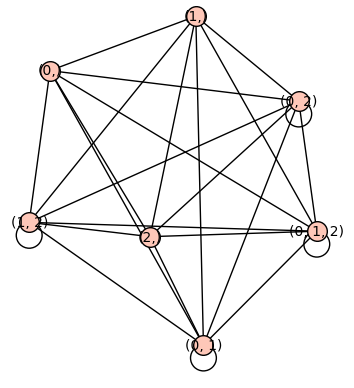

In [32]:
show(cliqueGraph(graphs.CompleteGraph(3)))

In [1]:
def comm(G):
    """
    Return the commutator graph of a group G
    """
    elems = G.list()
    
    return Graph([elems,lambda x,y: x*y == y*x])

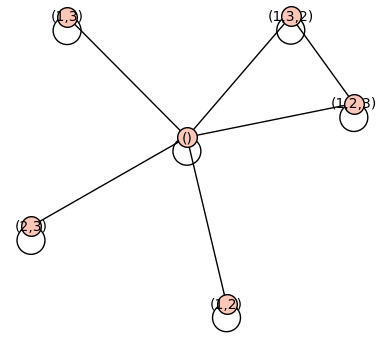

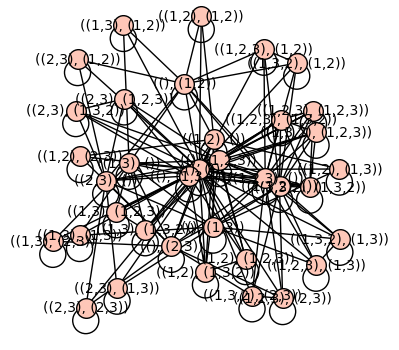

In [34]:
G = comm(DihedralGroup(3))

show(G)

show(G.tensor_product(G))

In [36]:
# This is another odd graph. 
# the subgroup generated by <ab,ac,x,y> IS a raag
# but is not obviously a subgraph of this house
house = Graph([['a','b','c','x','y'],[('a','b'),('a','c'),('b','c'),('b','x'),('b','y'),('c','x'),('c','y'),('x','y')]])

# in fact, <ab,ac,x,y> is A(teepee)
teepee = Graph([['t1','t2','t3','s'],[('t1','t2'),('t2','t3'),('t1','t3'),('t1','s')]])

testGraph(house,30)

In [ ]:
monadGraph(house,30)[0].show(method='js', link_distance=1000, charge=-500)

In [51]:
# Ok - so given any embedding AGamma --> ADelta, 
# we get an induced embedding Gamma --> Clique(Extension(Delta))
# question: converse?
# conjecture: no.
# to show this, let's try to find a Gamma embedding into Clique(Extension(Delta))
# with the property that Gamma does _not_ embed in Monad(Delta)

# n = 8 # number of vertices
# d = 3  # degree of each vertex

# G = graphs.RandomRegular(n,d)

# The house seems like as good a first try as any...
ceG = cliqueGraph(extensionGraph(house, 50)[0])
print("done clique of extension graph")

mG = monadGraph(house, 50)[0]
print("done evaluating monad graph")

for i in range(5000):
    print("trial ", i, " of 5000")
    
    # get a random subgraph where we keep each vtx with some probability.
    # at each multiple of 1000, increase the probability of keeping a vtx
    modifier = 1 + (i // 1000)
    trial = ceG.random_subgraph(.1 * modifier)
    
    subgraph = mG.subgraph_search(trial, induced=True) # it MUST be induced to be an embedding
    
    if subgraph == None:
        # then trial isn't a subgraph of the monad graph, but IS a subgraph of clique(extension(graph))
        print("got one!")
        print("look at the induced subgraph of ceG with the following verties:")
        print(trial.vertices())
        trial.show()
        break

done clique of extension graph
done evaluating monad graph
trial  0  of 5000
trial  1  of 5000
trial  2  of 5000
trial  3  of 5000
trial  4  of 5000
trial  5  of 5000
trial  6  of 5000
trial  7  of 5000
trial  8  of 5000
trial  9  of 5000
trial  10  of 5000


KeyboardInterrupt: 

In [5]:
for n in range(1,10):
    CSn = comm(SymmetricGroup(n))
    CSn.allow_loops(False)
    print(n, CSn.is_perfect())
    
# False for n >= 5. Notice since S_n \leq S_{n+1}, once CS_n isn't perfect, neither are larger ns.
# This follows from the strong perfect graph theorem

1 True
2 True
3 True
4 True
5 False
6 False
7 False


KeyboardInterrupt: 

In [11]:
for n in range(1,100):
    CSn = comm(DihedralGroup(n))
    CSn.allow_loops(False)
    print(n)
    if not CSn.is_perfect():
        print(n, CSn.is_perfect())
    
# hm.... it seems like the dihedral groups might always be perfect?

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


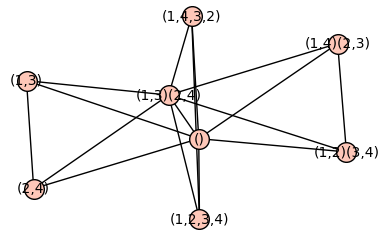

In [15]:
n = 4
CSn = comm(DihedralGroup(n))
CSn.allow_loops(False)
show(CSn)